# PLEASE READ BEFORE STARTING
1. **Don't edit this file, make a copy first:**
  * Click on File -> Save a copy in Drive

2. Also do the following:
  * Click on Runtime -> Change runtime type -> Make sure hardware accelerator is set to GPU

# FastAI Tutorial
Neural networks can be used for a whole host of tasks.
The most basic of these though is image classification.
Hence, today we'll go through using supervised learning to predict an images class/label from the CIFAR-10 dataset.

We'll be using a library called FastAI which is built ontop of PyTorch to abstract away all the nitty-gritty details.
Instead we can focus on comparing, contrarsting and understanding the different concepts we are able to use (like pretraining).
By the end of this you should be roughly familiar with all the major concepts and theory behind basic neural nets!

There's a lot going on here, so let's get going!

## Importing Libraries
Before we dive into the image classification task for this workshop, it is important the relevant libraries.


Note here that we're importing everything from fastai's vision package, which is useful here but not in practice.

In [1]:
!pip install fastai --upgrade --quiet

     |████████████████████████████████| 194kB 6.7MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 


In [2]:
from fastai.vision.all import *

# Dataset Setup
The first step for anything data related is to read a dataset and split the data into seperate training and validation partitions.
In this tutorial we will be using the CIFAR-10 dataset, which includes 60,000 images, each belonging to one of ten categories.
The dataset was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. More information on the dataset can be found here: https://www.cs.toronto.edu/~kriz/cifar.html

## Initialising the Data into a pipeline
To start, we will download the CIFAR-10 dataset and extract all the images from it.

In [3]:
path = untar_data(URLs.CIFAR) # Downloads url and unzips to folder destination

Next we will initialise an instance of the 'DataBlock' class from the FastAI library. Which is a generic container that allows us to build a "smart" dataset called a dataloader, that contains the images seperated into training and validation sets, with their class attached to them. The purpose of the dataloader is that it specified a pipeline in which the model will receive data.

We use the function ImageDataLoaders() to establish the dataloader by passing the path to the dataset, and the proportion of the dataset we wish to dedicate to the validation set.

The validation dataset provides a way to check whether we are actually learning how to classify images or just overfitting the data (i.e. the model has just memorised which image belongs to which class).
To do this we can create a validation dataset which the model doesn't train with, but insntead is used to "test" how well it does "out-of-sample".

In this case we've used 20% of CIFAR-10's 60,000 images for validation (but you can change this).

In [4]:
data = ImageDataLoaders.from_folder(path=path, valid_pct=0.2)

## Validating the dataset
Before we proceed, it is important to validate the data to ensure that we do not have an incomplete dataset, a dateset with incorrect preprocessing, and more importantly to understand the data we are working in before we begin training.

We know that CIFAR-10 has 60,000 images, lets start by verifying that we correctly set 20% of the dataset to the validation set.

In [5]:
print("Training Set Size = " + str(len(data.train_ds)))
print("Validiation Set Size = " + str(len(data.valid_ds)))
print("Total Dataset Size = " + str(len(data.train_ds) + len(data.valid_ds)))

Training Set Size = 48000
Validiation Set Size = 12000
Total Dataset Size = 60000


We can also validate the dataset by checking a random batch to view the images with their respective labels.

Notice that the images are blurry, this is because the CIFAR dataset is used to train neural nets to identify far away objects that are often pixilated. The images have been taken while the camera setting was zoomed in to maximum.

Hence, this image classification is a real life example of where AI can be applied.

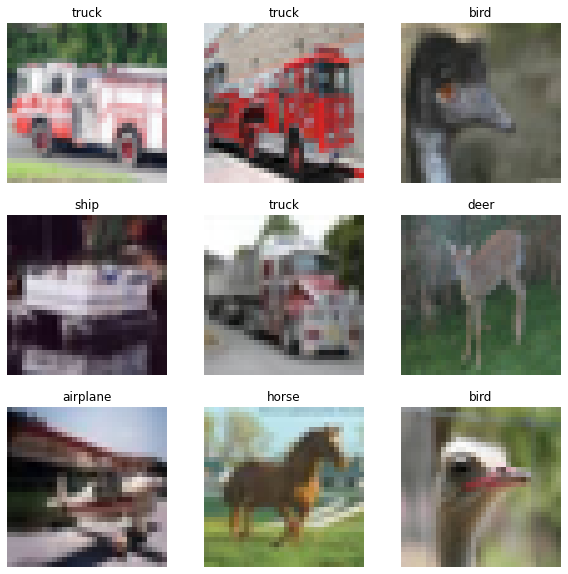

In [6]:
data.show_batch(figsize=(10,10))

# Model Setup
## Transfer Learning
Transfer learning allows us to repurpose a model trained for one task to many others.
This means our research and practical testing of image classification techniques using neural nets on CIFAR-10 can also be used for other datasets (and even other broad domains like Natural Language Processing).

This is why transfer learning is one of the most fundemental aspect of deep learning.
We can find several examples of this, including:
- A model trained for the ImageNet competition can be repurposed to recognise between different dog breeds
- A model trained on ImageNet can be repurposed to help us classify whether an image is a 'plane' or a 'dog'
- A language model trained on Spanish could be adapted and repurposed for French/Italian

The primary benefit of transfer learning is that we can use the same "toolkit" or "basic techniques" for a very wide variety of complex problems.
Hence, we have solid foundations which we can build up upon.
This cuts down on training time *substantially*.


In this example we're using a pretrained *ResNet-34* (more advanced model) as our base architecture, then retraining it to adapt it to classify our data.

In [7]:
learn = cnn_learner(data, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


# Training
## Determining the Learning Rate
An important thing to figgure out is what learning rate to use.
It's a hard problem to solve, but we can nudge ourselves in the right direction by finding out how changing our learning rate effects the loss initially.

We see this with FastAI's `lr_find()`.
It provides the minimum learning rate (divided by 10) and the point of steepest descent.

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=2.2908675418875646e-06)

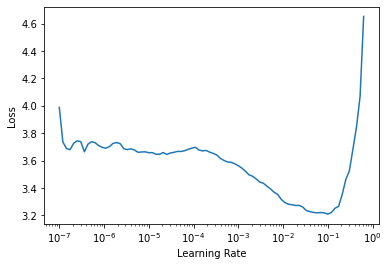

In [8]:
learn.lr_find()

You can try and pick the best learning rate and put it into the `fine_tune()` method below (in the next section) to see how it changes your results.
If you try a few different values, you'll soon see that your choice greatly effects the results!

## Training Time!
We are now ready to begin training, to start, we use the `fine_tune()` method from the `cnn_trainer` to cycle through our training epochs, at a base learning rate. For this training, we will go over four epochs, click the code block below to begin training.

NOTE: `fine_tune()` uses superconvergence/the one-cycle policy to modify the learning rate. This aims to increase the learning rate where possible (for example towards the beginning) to speed up training and get better results by avoiding local optima

NOTE 2: Slight bug that has been picked up where training loss and validation loss have sometimes gone over 1, in these cases, the loop restarts.


In [10]:
learn.fine_tune(4, 10^(-4))

epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.100750,01:36


epoch,train_loss,valid_loss,accuracy,time
0,nan,nan,0.100750,01:35
1,nan,nan,0.100750,01:35
2,nan,nan,0.100750,01:35
3,nan,nan,0.100750,01:37


While it is training, you may hopefully notice that the training loss and validation loss get lower over time, and the accuracy may increase as the model learns.



## Saving Model Weights
Once training has completed, we should save our models weights (so we can use or pretrain from it later).

This could also allow:
- Reverting to a previous model
- Tracking a models progress through special version-control

Model weights can be simply reloaded with `learner.load('some-name')`

In [11]:
learn.save('trained-lr-default')

Path('/root/.fastai/data/cifar10/models/trained-lr-default.pth')

# Evaluation
Once the training has been completed, we need to gauge how good/bad our model is.

## Sample Predictions
We can view some predictions with our newly trained model with the `show_results()` method. Activate the block below to see how it went!

The text at the top indicates the actual class of the image, the bottom text indicates the predicted class, if they're green, our model successfully predicted correctly.

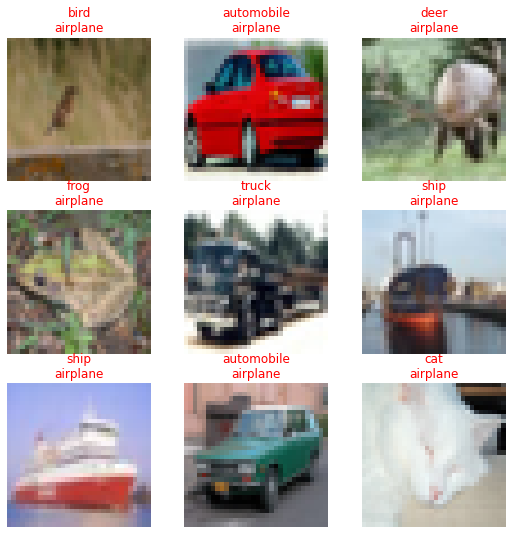

In [12]:
learn.show_results()

Viewing a sample batch of predictions is visually appealing, however there are more appropriate metrics to validate the model.

## Model Validation
It is important to validate our models with appropriate metrics to determine how well the model is performing, and whether or not further investigation is required. Today we will be doing using a Confusion Matrix and viewing our top losses. We will start by creating an instance of the `ClassificationInterpretation` class from our model in order to begin.

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

### Confusion Matrix
A Confusion Matrix can be used to determine where our model is producing false positives or false negatives. Click below to see what happened!

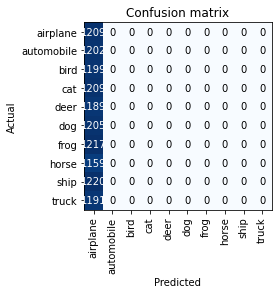

In [14]:
interp.plot_confusion_matrix()

### Top Losses
We can also produce a set of images that fastai considers 'top losses' with the `plot_top_losses()` method. The images are considered 'top losses' based on the probability that the prediction was correct. The images with a probability of 1 technically don't have a probability of 1, it's an softmax bug within FastAI.

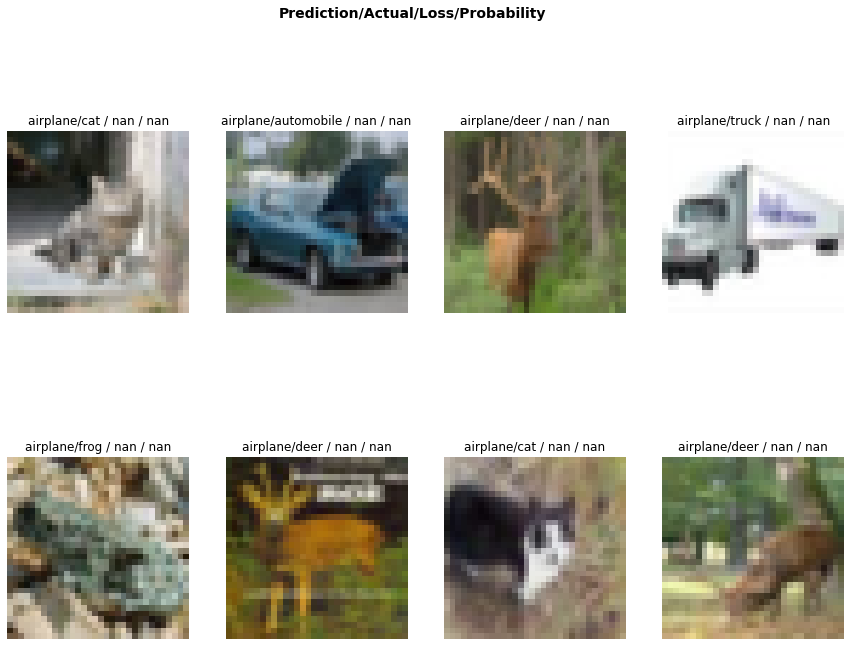

In [15]:
interp.plot_top_losses(8, figsize=(15,11))

Before we continue onto the group evaluation, why don't you try set your own learning rate and see what happens. To do this, go back to the model setup section and run the code blocks up until the training block. In the `learn.fine_tune(4)` line, we can pass a base learning rate as the second argument, which can look something like this:


```
learn.fine_tune(4, #learning_rate_here)
```

Set the learning rate to anything you believe will increase the accuracy of your model, you might want to decide as a breakout room seperate learning rates you will each try. While it is training, proceed to the group evaluation. 

Remember when it completes to save the weights under a new name.

## Group Evaluation
As a breakout room, discuss how your models performed.
Try and consider areas you believed they performed well in, along with where you think they could improve.
Think about why there may be some common classes where confusion occurs between the actual and predicted classes while you wait for the results of your new training.
Feel free to additionally discuss the effect of learning rates once again.